# Plan 🧭
##### Choose the most critical metric for RAG for my use case (banking chatbot)
1. relevancy
2. groundedness
...

## Relevancy evaluation

#### Questions
- what is relevancy in LLM context?
- how to measure it?
- what are the common approaches?
- what are the common pitfalls?
- what are the best practices?
- how to implement it?
- how to validate it?
- how to benchmark it?
- how to improve it?

#### 1. Embedding based relevancy evaluator 

- To check relevancy, we can use cosine similarity between embeddings of the question and the answer.
- We can use OpenAI's embedding model to generate embeddings for both the question and the answer.
- Then, we can calculate the cosine similarity between the two embeddings.
- If the cosine similarity is above a certain threshold, we can consider the answer to be relevant to the question.
- We can use the following steps to implement this:
    - Generate embeddings for the question and the answer using OpenAI's embedding model
    - Calculate the cosine similarity between the two embeddings
#### 2. LLM-as-a-judge evaluator

- We can use a language model to evaluate the relevancy of the answer to the question
- by prompting the model with the question and the answer and asking it to rate the relevancy on a scale of 1 to 10.
- We can use the following steps to implement this:
    - Create a prompt that includes the question and the answer
    - Use the language model to generate a response to the prompt
    - Parse the response to extract the relevancy rating

## Sources 📚
### Microsoft
- https://github.com/Azure/azure-sdk-for-python/tree/azure-ai-evaluation_1.0.0b5/sdk/evaluation/azure-ai-evaluation
- https://github.com/Azure/azure-sdk-for-python/blob/azure-ai-evaluation_1.0.0b5/sdk/evaluation/azure-ai-evaluation/azure/ai/evaluation/_evaluators/_relevance/relevance.prompty
- Azure AI search tailored relevance evaluator - https://github.com/Azure-Samples/azureai-samples/blob/main/scenarios/evaluate/Supported_Evaluation_Metrics/RAG_Evaluation/Optimize_RAG_with_Document_Retrieval_Evaluator.ipynb

### Ragas
- https://docs.ragas.io/en/stable/getstarted/rag_eval/#load-documents

## Groundedness

#### 1. Entity-based groundedness evaluator
- To check groundedness, we can extract entities from the answer and check if they are present in the context.
- We can use a named entity recognition (NER) model to extract entities from the answer.
- Then, we can check if the extracted entities are present in the context.
- If a certain percentage of the extracted entities are present in the context, we can consider the answer to be grounded.
- We can use the following steps to implement this:
    - Use a NER model to extract entities from the answer
    - Check if the extracted entities are present in the context
#### 2. LLM-as-a-judge evaluator
- We can use a language model to evaluate the groundedness of the answer by prompting the model with the context and the answer
- and asking it to rate the groundedness on a scale of 1 to 10.
- We can use the following steps to implement this:
    - Create a prompt that includes the context and the answer
    - Use the language model to generate a response to the prompt
    - Parse the response to extract the groundedness rating

In [29]:
from openai import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
import os
import sys
sys.path.append(os.path.abspath(".."))
from test_data.utils import save_to_file
import time
import json
import io
import plotly.express as px
from dash import Dash, dcc, html
import textwrap

In [8]:
prompt = """
You are a text analytics, who evaluates relevance of an answer to a given question.
You will be given a question and an answer, the goal is to deeply analyse it and come up with a score from 0 to 1, where 0 means the answer is completely irrelevant, and 1 - is the answer is absolutely relevant. Always conclude your evaluation with detailed but concise explanation of your scoring, supported by concrete examples and other arguments.
The example format for your answer is a JSONL file with the following structure:
"input": "<provided question>", "output": "<provided answer>", "score": "<your score>", "score_explanation": "<your score explanation>"\

Example:
Question: I see a charge on my credit card for $2,500 to "ElectroMax" on 2025-08-01 that I don't recognize. The card is 4111 1111 1111 1111. Please investigate and take action. 
Answer: Immediate response (sensitive action): 1) Confirm identity: ask customer to verify full name, date of birth (30), and last 4 of account (6789) or last 4 of card (1111). 2) While verifying, place an immediate temporary block on card number 4111 1111 1111 1111 to prevent further charges. 3) Create a fraud case with severity: high; record: merchant "ElectroMax", amount $2,500, date 2025-08-01, transaction ID (if available). 4) Provisionally credit the $2,500 pending investigation (explain provisional credit policy and timeline). 5) Start dispute process: request client-supplied evidence (receipt, photos, merchant communication), and confirm whether customer wants a replacement card issued. 6) Notify customer via their preferred contact_method (email: john.doe@example.com) and inform that two-factor authentication will be required for any account changes. 7) Next steps for customer: respond with a copy/photo of the cardholder’s ID and a short written statement if prompted, confirm whether they made any recent authorized transactions or gave card to a family member. 8) Internal actions: escalate to fraud team, monitor account 123456789 and routing 987654321 for suspicious transfers, log event with timestamp, agent ID, and actions taken. Estimated resolution time: 7–10 business days for full investigation; provisional credit may take 3–5 business days. If urgent, provide phone support option to +1-202-555-0199.

Your response in JSONL format:
{{"input": "I see a charge on my credit card for $2,500 to "ElectroMax" on 2025-08-01 that I don't recognize. The card is 4111 1111 1111 1111. Please investigate and take action.", "output": "Immediate response (sensitive action): 1) Confirm identity: ask customer to verify full name, date of birth (30), and last 4 of account (6789) or last 4 of card (1111). 2) While verifying, place an immediate temporary block on card number 4111 1111 1111 1111 to prevent further charges. 3) Create a fraud case with severity: high; record: merchant "ElectroMax", amount $2,500, date 2025-08-01, transaction ID (if available). 4) Provisionally credit the $2,500 pending investigation (explain provisional credit policy and timeline). 5) Start dispute process: request client-supplied evidence (receipt, photos, merchant communication), and confirm whether customer wants a replacement card issued. 6) Notify customer via their preferred contact_method (email: john.doe@example.com) and inform that two-factor authentication will be required for any account changes. 7) Next steps for customer: respond with a copy/photo of the cardholder’s ID and a short written statement if prompted, confirm whether they made any recent authorized transactions or gave card to a family member. 8) Internal actions: escalate to fraud team, monitor account 123456789 and routing 987654321 for suspicious transfers, log event with timestamp, agent ID, and actions taken. Estimated resolution time: 7–10 business days for full investigation; provisional credit may take 3–5 business days. If urgent, provide phone support option to +1-202-555-0199.", "score": "0.798", "score_explanation": "The answer is relevant, but there is some redundant information and some missing points. For example this part 'Immediate response (sensitive action)' is confusing. Another point is redandancy of steps, instead 8, there could be 5. Strengths and weaknesses: ... . The answer not totally answers the customer question about charing recognition."}}

Here is the question and answer to evaluate:
Question: {question}
Answer: {answer}
"""

In [2]:
dev_prompt = """
You are a text analytics, who evaluates relevance of an answer to a given question.
You will be given a question and an answer, the goal is to deeply analyse it and come up with a score from 0 to 1, where 0 means the answer is completely irrelevant, and 1 - is the answer is absolutely relevant. 
Your response should always be in a JSONL format with the following structure:
{{"input": "<provided question>", "output": "<provided answer>", "score": "<your score>", "score_explanation": "<your score explanation>"}}

For the 'score_explanation' field provide concise explanation supported by solid, concrete examples and other arguments with max 100 words. Keep reasoning and iterating until you are sure the explanation meets the requirements.
"""

In [ ]:
client = OpenAI()
test_questions_path = "../test_data/test_questions/344342342.jsonl"
df = pd.read_json(test_questions_path, lines=True)
relatedness_fn = lambda x, y: 1 - spatial.distance.cosine(x, y)

query_embedding = client.embeddings.create(
    model='text-embedding-3-small',
    input=df.iloc[0]['input'],
)
response_embedding = client.embeddings.create(
    model='text-embedding-3-small',
    input=df.iloc[0]['output'],
)
cosine_similarity = relatedness_fn(
    query_embedding.data[0].embedding,
    response_embedding.data[0].embedding
)

response = client.chat.completions.create(
    messages=[
        {'role': 'user', 'content': prompt.format(question=df.iloc[0]['input'],answer=df.iloc[0]['output'])}
    ],
    model='gpt-5-mini',
    reasoning={
        "effort": "low",
        "summary": "auto"
    }
)
response_text = response.choices[0].message.content
data = json.loads(response_text)
data['cosine_similarity'] = cosine_similarity
df = pd.read_json(io.StringIO(json.dumps(data)), lines=True)
df.to_csv(f'{int(time.time())}.csv', index=False)

[ResponseReasoningItem(id='rs_68d3edaa91948190b6d77d7da327a5ed0541eb96abe9c3f7', summary=[Summary(text='**Evaluating JSONL output**\n\nI need to output JSONL that includes fields like input, output, score, and score_explanation. The answer is quite relevant since it addresses issues like investigating, blocking a card, and provisional credit. However, it includes problematic PII like account numbers, making up details not given, which could compromise safety. While it mostly answers the question well, I think I should score it around 0.9, due to both good alignment and invented data. Let’s refine the explanation and provide examples for clarity.', type='summary_text')], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_68d3edb3e55c8190a219d837ddec97920541eb96abe9c3f7', content=[ResponseOutputText(annotations=[], text='"input": "I see a charge on my credit card for $2,500 to \\"ElectroMax\\" on 2025-08-01 that I don\'t recognize. The car

### Playing around with reasoning models (gpt-5)
*https://platform.openai.com/docs/guides/reasoning-best-practices*

In [ ]:
client = OpenAI()
test_questions_path = "../test_data/test_questions/1757949303.jsonl"
df = pd.read_json(test_questions_path, lines=True)

responses = []
for index, row in df.iterrows():
    context = [
        { "role": "developer", "content": dev_prompt },
        { "role": "user", "content": f"Question: {row['input']}\nAnswer: {row['output']}" }
    ]
    response = client.responses.create(
        input=context,
        model='gpt-5',
        reasoning={
            "effort": "medium",
            "summary": "auto"
        }
    )
    responses.append(response.output[1].content[0].text)

df = pd.read_json(io.StringIO("\n".join(responses)), lines=True)
df.to_csv(f'eval_results/{int(time.time())}.csv', index=False)


### Plotting
Things to update:
- using another python library, create a plot that has an interactive unfloding text tooltip with score explanation per each plot point

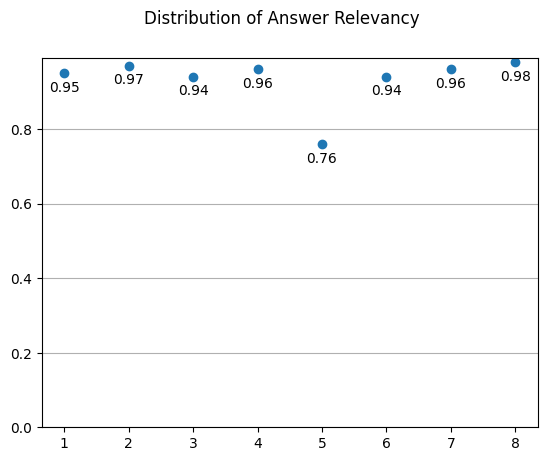

In [ ]:
df = pd.read_csv('eval_results/1758788278.csv')
xpoints = [i + 1 for i in df.index.tolist()]
ypoints = df["score"].tolist()
plt.grid(axis='y')    
plt.suptitle("Distribution of Answer Relevancy")
plt.plot(xpoints, ypoints, marker='o', ls = '')
plt.ylim(bottom=0)
for x, y in zip(xpoints, ypoints):
    plt.text(x, y - 0.02, f"{y:.2f}", ha='center', va='top', fontsize=10)
plt.show()

### Playing with Plotly + Dash

In [63]:
df = pd.read_csv('eval_results/1758788278.csv')
xpoints = [i + 1 for i in df.index.tolist()]
line_width = 70
df['score_explanation'] = df['score_explanation'].apply(lambda x: textwrap.fill(x, width=line_width).replace('\n', '<br>'))
df['input'] = df['input'].apply(lambda x: textwrap.fill(x, width=line_width).replace('\n', '<br>'))
df['output'] = df['output'].apply(lambda x: textwrap.fill(x, width=line_width).replace('\n', '<br>'))
fig = px.scatter(df, x=xpoints, y="score", title="Relevance Score Distribution", custom_data=['input', 'output', 'score_explanation'])
fig.update_layout(
        yaxis_title="Relevance Score",
        xaxis_title="Sample #",
        yaxis_range=[0, 1]
    )
fig.update_traces(
    hovertemplate=
        '<b>Question:</b> %{customdata[0]}<br><br>' +
        '<b>Answer:</b> %{customdata[1]}<br><br>' +
        '<b>Score:</b> %{y}<br>' +
        '<b>Explanation:</b> %{customdata[2]}'
)
fig.write_html("relevance_chart.html")

app = Dash('main')
app.layout = html.Div([
    dcc.Graph(figure=fig)
])
app.run()